# Tarea N°02

## Instrucciones

1.- Completa tus datos personales (nombre y rol USM) en siguiente celda.


* __Nombre__: Ariadne Sandoval Roa

* __Rol__: 201520503-0

2.- Debes _pushear_ este archivo con tus cambios a tu repositorio personal del curso, incluyendo datos, imágenes, scripts, etc.

3.- Se evaluará:
    - Soluciones
    - Código
    - Que Binder esté bien configurado.
    - Al presionar  `Kernel -> Restart Kernel and Run All Cells` deben ejecutarse todas las celdas sin error.

## I.- Clasificación de dígitos


En este laboratorio realizaremos el trabajo de reconocer un dígito a partir de una imagen.


![rgb](https://www.wolfram.com/language/11/neural-networks/assets.en/digit-classification/smallthumb_1.png)

El objetivo es a partir de los datos, hacer la mejor predicción de cada imagen. Para ellos es necesario realizar los pasos clásicos de un proyecto de _Machine Learning_, como estadística descriptiva, visualización y preprocesamiento. 

* Se solicita ajustar al menos tres modelos de clasificación:
 * Regresión logística
 * K-Nearest Neighbours 
 * Uno o más algoritmos a su elección [link](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) (es obligación escoger un _estimator_ que tenga por lo menos un hiperparámetro). 
 
 
* En los modelos que posean hiperparámetros es mandatorio buscar el/los mejores con alguna técnica disponible en `scikit-learn` ([ver más](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator)).
* Para cada modelo, se debe realizar _Cross Validation_ con 10 _folds_ utilizando los datos de entrenamiento con tal de determinar un intervalo de confianza para el _score_ del modelo.
* Realizar una predicción con cada uno de los tres modelos con los datos _test_ y obtener el _score_. 
* Analizar sus métricas de error (**accuracy**, **precision**, **recall**, **f-score**)



### Exploración de los datos
A continuación se carga el conjunto de datos a utilizar, a través del sub-módulo `datasets` de `sklearn`.

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import warnings
import timeit

warnings.filterwarnings("ignore")

sns.set_palette("deep", desat=.6)
sns.set(rc={'figure.figsize':(20,30)})
%matplotlib inline

In [3]:
digits_dict = datasets.load_digits()
print(digits_dict["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [4]:
digits_dict.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [5]:
digits_dict["target"]

array([0, 1, 2, ..., 8, 9, 8])

A continuación se crea dataframe declarado como `digits` con los datos de `digits_dict` tal que tenga 65 columnas, las 6 primeras a la representación de la imagen en escala de grises (0-blanco, 255-negro) y la última correspondiente al dígito (`target`) con el nombre _target_.

In [6]:
digits = (
    pd.DataFrame(
        digits_dict["data"],
    )
    .rename(columns=lambda x: f"c{x:02d}")
    .assign(target=digits_dict["target"])
    .astype(int)
)

digits.head()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


### Ejercicio 1
**Análisis exploratorio:** Realiza tu análisis exploratorio, no debes olvidar nada! Recuerda, cada análisis debe responder una pregunta.

Algunas sugerencias:

* ¿Cómo se distribuyen los datos?
* ¿Cuánta memoria estoy utilizando?
* ¿Qué tipo de datos son?
* ¿Cuántos registros por clase hay?
* ¿Hay registros que no se correspondan con tu conocimiento previo de los datos?

In [7]:
digits.describe() #vemos el dataframe

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496,4.490818
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122,2.865304
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000,4.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000,7.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,9.000000


65


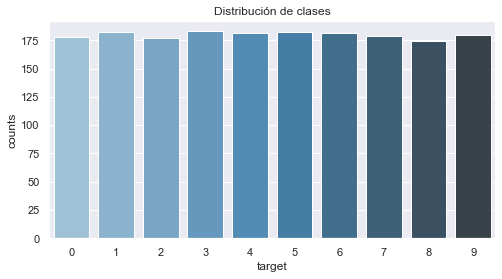

In [8]:
print(len(digits.columns))
gr = digits.groupby(['target']).size().reset_index(name='counts')
fig, ax = plt.subplots(figsize=(8,4),nrows=1)
sns.barplot(data=gr, x='target', y='counts', palette="Blues_d",ax=ax)
ax.set_title('Distribución de clases')
plt.show()
print("")

Notemos que las clases estan distribuidas uniformemente

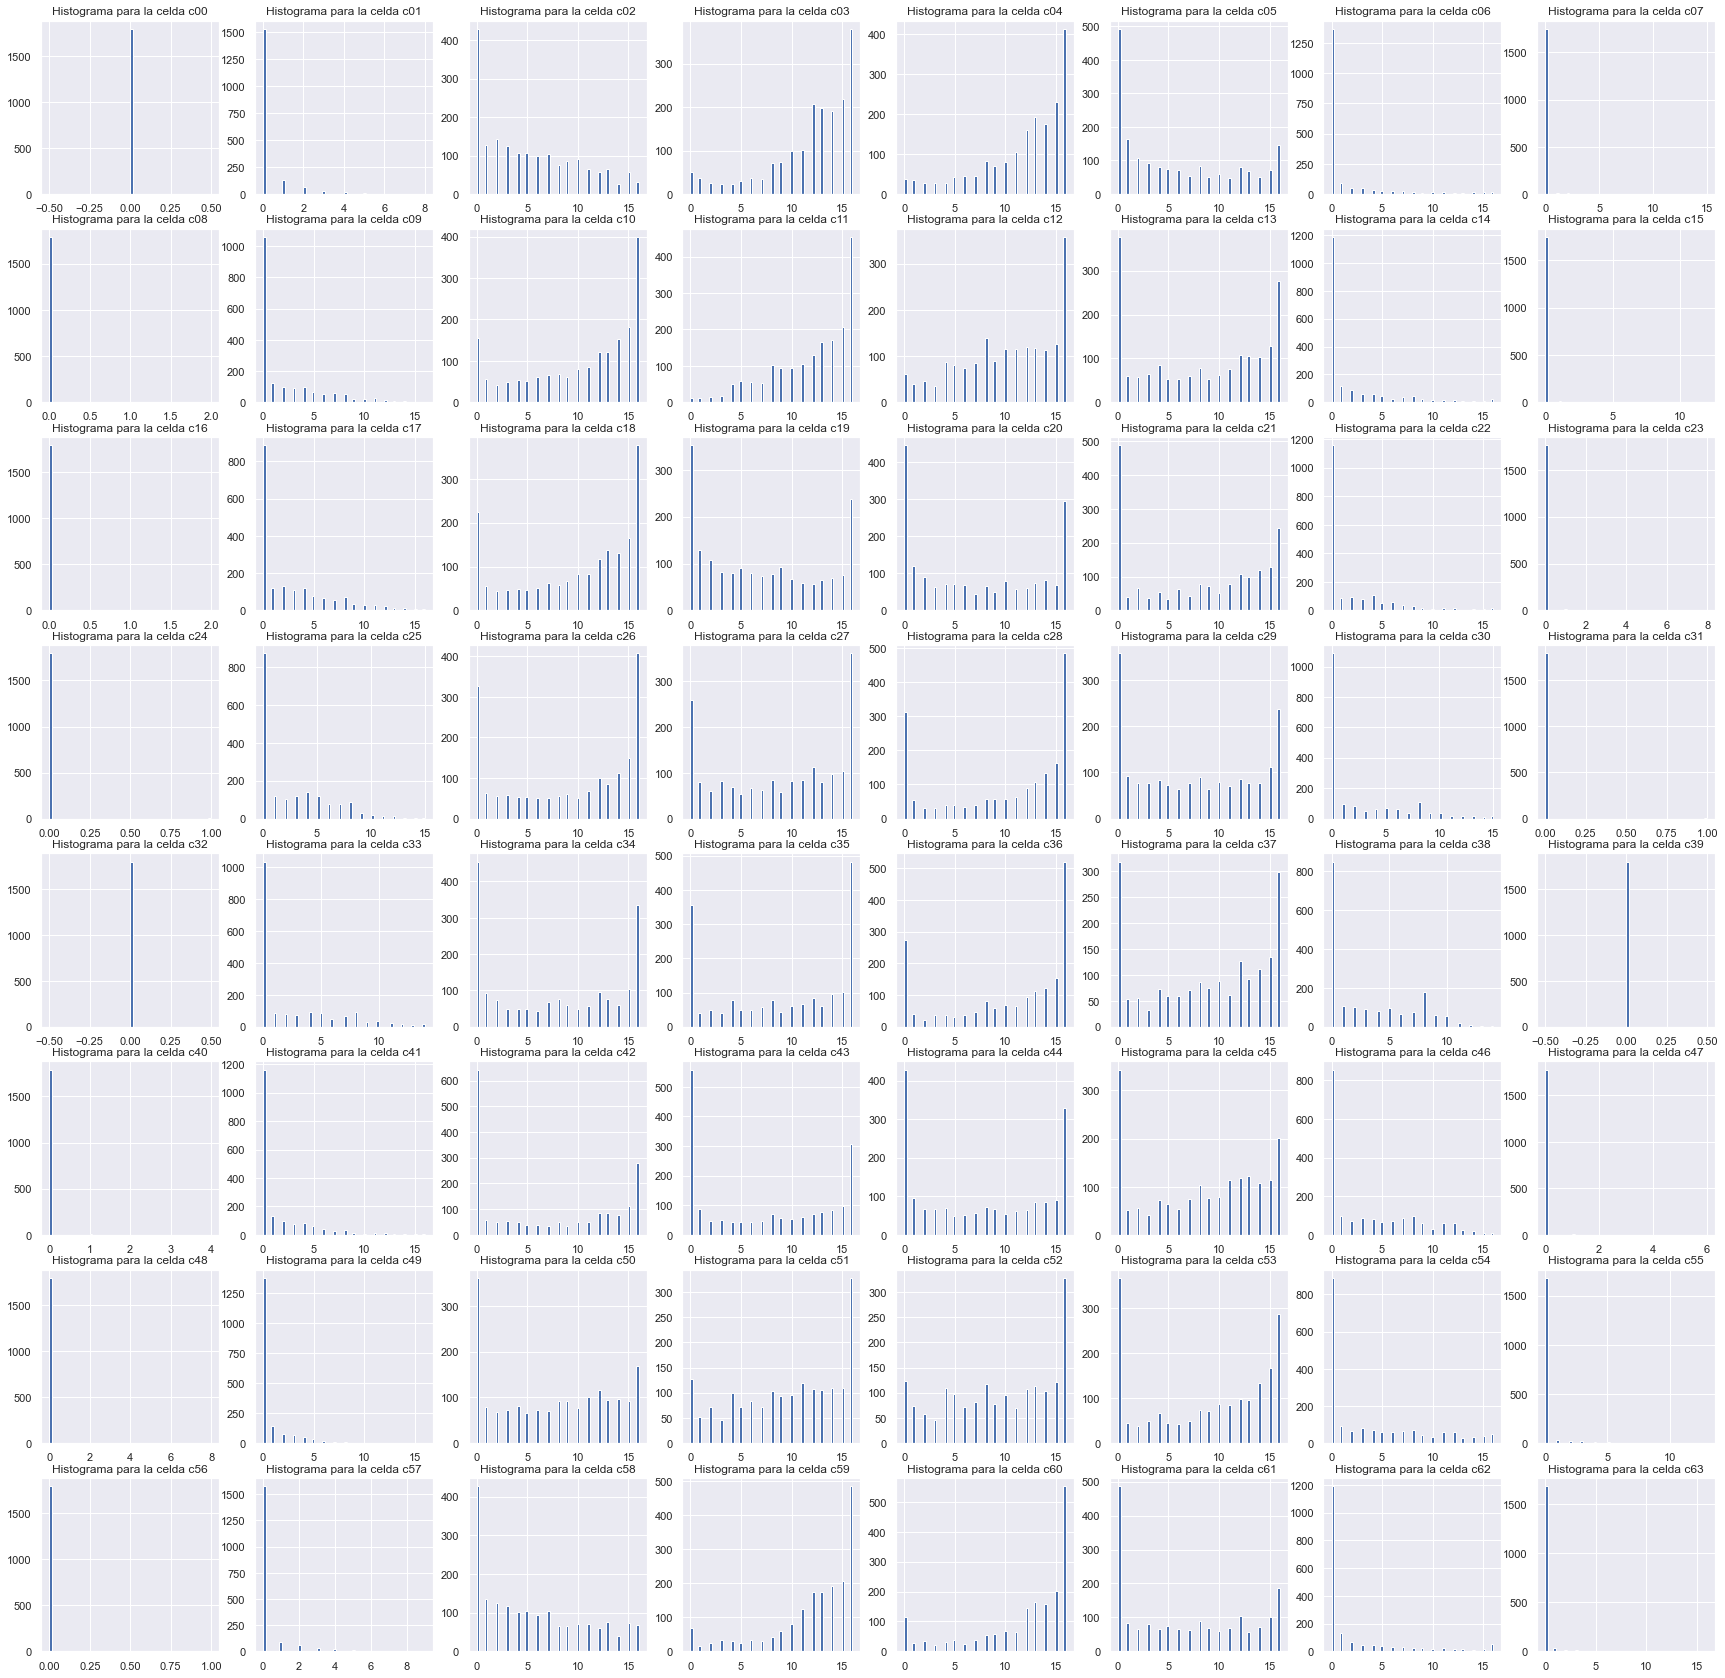

In [9]:
df=digits.drop(['target'],axis=1) #df sin target
figure(num=None, figsize=(30, 30)) #Ajustamos nuestra ventana de ploteo
k=1 #Establesemos un contador para el ploteo.
for i in df.columns: #recorrer columnas para generar histogramas
    plt.subplot(8,8,k)
    plt.hist(df[i], bins = 60)
    plt.title('Histograma para la celda '+i)
    k+=1

plt.show()

In [10]:
print("Los datos de distribuyen en arreglos de 64 casillas")

#Memoria ocupada
digits.info(memory_usage="deep")

#Registros por clase
for i in digits['target'].unique():
    mask= (digits['target']==i)
    k=len(digits[mask]['target'])
    print("La cantidad de registros de la clase",i,"es de",k)
    

digits.dtypes.unique() #Tipos de datos

digits.describe().T['count'].unique() #Todos tienen la misma cantidad de elementos

Los datos de distribuyen en arreglos de 64 casillas
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797 entries, 0 to 1796
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   c00     1797 non-null   int32
 1   c01     1797 non-null   int32
 2   c02     1797 non-null   int32
 3   c03     1797 non-null   int32
 4   c04     1797 non-null   int32
 5   c05     1797 non-null   int32
 6   c06     1797 non-null   int32
 7   c07     1797 non-null   int32
 8   c08     1797 non-null   int32
 9   c09     1797 non-null   int32
 10  c10     1797 non-null   int32
 11  c11     1797 non-null   int32
 12  c12     1797 non-null   int32
 13  c13     1797 non-null   int32
 14  c14     1797 non-null   int32
 15  c15     1797 non-null   int32
 16  c16     1797 non-null   int32
 17  c17     1797 non-null   int32
 18  c18     1797 non-null   int32
 19  c19     1797 non-null   int32
 20  c20     1797 non-null   int32
 21  c21     1797 non-null   int32
 

array([1797.])

### Ejercicio 2
**Visualización:** Para visualizar los datos utilizaremos el método `imshow` de `matplotlib`. Resulta necesario convertir el arreglo desde las dimensiones (1,64)  a (8,8) para que la imagen sea cuadrada y pueda distinguirse el dígito. Superpondremos además el label correspondiente al dígito, mediante el método `text`. Esto nos permitirá comparar la imagen generada con la etiqueta asociada a los valores. Realizaremos lo anterior para los primeros 25 datos del archivo.

In [11]:
digits_dict["images"][0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Visualiza imágenes de los dígitos utilizando la llave `images` de `digits_dict`. 

Sugerencia: Utiliza `plt.subplots` y el método `imshow`. Puedes hacer una grilla de varias imágenes al mismo tiempo!

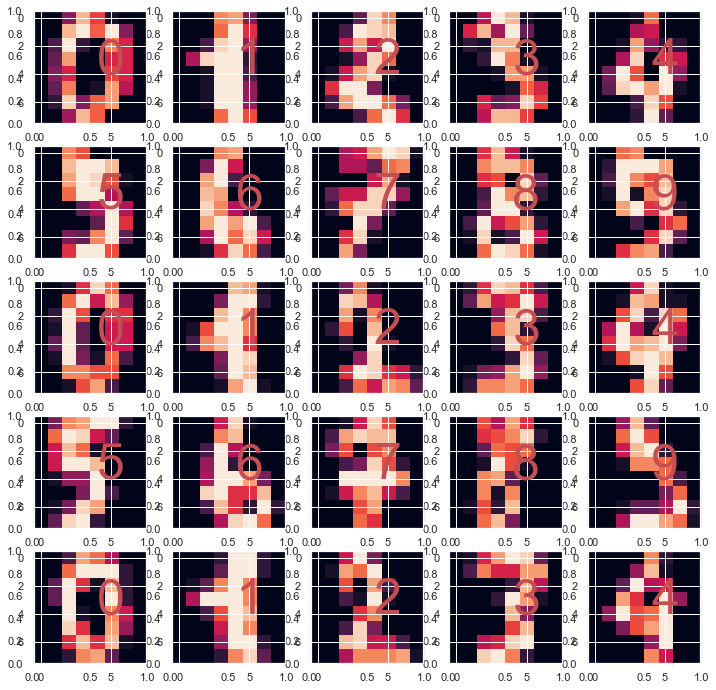

In [12]:
nx, ny = 5, 5
fig, axs = plt.subplots(nx, ny, figsize=(12, 12))
n=0
for i in range(1,26):
    etiqueta=['0','1','2','3','4','5','6','7','8','9']
    img=digits_dict["images"][i-1]
    fig.add_subplot(nx,ny,i)
    plt.imshow(img)
    plt.text(4,4,etiqueta[n],fontsize=50,color='r')
    n+=1
    if n==(len(etiqueta)):
        n=0
plt.show()

### Ejercicio 3

**Machine Learning**: En esta parte usted debe entrenar los distintos modelos escogidos desde la librería de `skelearn`. Para cada modelo, debe realizar los siguientes pasos:

* **train-test** 
 * Crear conjunto de entrenamiento y testeo (usted determine las proporciones adecuadas).
 * Imprimir por pantalla el largo del conjunto de entrenamiento y de testeo.
 
 
* **modelo**:
 * Instanciar el modelo objetivo desde la librería sklearn.
 * *Hiper-parámetros*: Utiliza `sklearn.model_selection.GridSearchCV` para obtener la mejor estimación de los parámetros del modelo objetivo.




* **Métricas**:
 * Graficar matriz de confusión.
 * Analizar métricas de error.



__Preguntas a responder:__

* ¿Cuál modelo es mejor basado en sus métricas?
* ¿Cuál modelo demora menos tiempo en ajustarse?
* ¿Qué modelo escoges?


In [13]:
X = digits.drop(columns="target").values
y = digits["target"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Largo Train: ", X_train.shape)
print("Largo Test: ", X_test.shape)

Largo Train:  (1437, 64)
Largo Test:  (360, 64)


In [14]:
#Regresión Logística

parameters = {'penalty': ['l1', 'l2', 'elasticnet'], 'C':[1, 10]}
reg = LogisticRegression()
gs = GridSearchCV(reg, parameters)
gs.fit(X_train, y_train)
print("Best: %f con %s" % (gs.best_score_, gs.best_params_))

#Entrenar modelo
clf = LogisticRegression(penalty='l2', C=1)
clf.fit(X_train, y_train)

#Predicción
y_pred= clf.predict(X_test)

#Evaluar
confusion_matrix(y_test, y_pred)

Best: 0.954063 con {'C': 1, 'penalty': 'l2'}


array([[33,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 33,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 33,  0,  1,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 44,  0,  1,  0,  0,  0],
       [ 0,  0,  1,  0,  0, 44,  1,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  1, 34,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0, 33,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0, 29,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  1, 38]], dtype=int64)

In [15]:
#Métricas
target_names = ['numero '+ str(i) for i in range(0,10)]
print(classification_report(y_test, y_pred, target_names=target_names, digits=5))

              precision    recall  f1-score   support

    numero 0    1.00000   1.00000   1.00000        33
    numero 1    0.96552   1.00000   0.98246        28
    numero 2    0.97059   1.00000   0.98507        33
    numero 3    0.97059   0.97059   0.97059        34
    numero 4    1.00000   0.95652   0.97778        46
    numero 5    0.91667   0.93617   0.92632        47
    numero 6    0.94444   0.97143   0.95775        35
    numero 7    1.00000   0.97059   0.98507        34
    numero 8    0.96667   0.96667   0.96667        30
    numero 9    0.97436   0.95000   0.96203        40

    accuracy                        0.96944       360
   macro avg    0.97088   0.97220   0.97137       360
weighted avg    0.96994   0.96944   0.96952       360



In [16]:
# KNN

parameters = {'n_neighbors':[1, 10]}
knn = KNeighborsClassifier()
gs = GridSearchCV(knn, parameters)
gs.fit(X_train, y_train)
print("Best: %f con %s" % (gs.best_score_, gs.best_params_))

#Entrenar modelo
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)

#Predicción
y_pred= clf.predict(X_test)

#Evaluar
confusion_matrix(y_test, y_pred)

Best: 0.986082 con {'n_neighbors': 1}


array([[33,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 33,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 34,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 45,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 46,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 35,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 33,  0,  1],
       [ 0,  1,  0,  0,  0,  0,  0,  0, 28,  1],
       [ 0,  0,  0,  1,  1,  1,  0,  0,  0, 37]], dtype=int64)

In [17]:
#Métricas
target_names = ['numero '+ str(i) for i in range(0,10)]
print(classification_report(y_test, y_pred, target_names=target_names, digits=5))

              precision    recall  f1-score   support

    numero 0    1.00000   1.00000   1.00000        33
    numero 1    0.93333   1.00000   0.96552        28
    numero 2    1.00000   1.00000   1.00000        33
    numero 3    0.97143   1.00000   0.98551        34
    numero 4    0.97826   0.97826   0.97826        46
    numero 5    0.97872   0.97872   0.97872        47
    numero 6    0.97222   1.00000   0.98592        35
    numero 7    1.00000   0.97059   0.98507        34
    numero 8    1.00000   0.93333   0.96552        30
    numero 9    0.94872   0.92500   0.93671        40

    accuracy                        0.97778       360
   macro avg    0.97827   0.97859   0.97812       360
weighted avg    0.97816   0.97778   0.97771       360



In [18]:
#SVM

from sklearn.svm import SVC
parameters = {'kernel':('linear', 'rbf'), 'C':range(10)}
sv = svm.SVC()
gs = GridSearchCV(sv, parameters)
gs.fit(X_train, y_train)
print("Best: %f con %s" % (gs.best_score_, gs.best_params_))

from sklearn.svm import SVC

#Entrenar modelo
clf = SVC(kernel= 'rbf', C=7)
%timeit clf.fit(X_train, y_train)

#Predicción
y_pred= clf.predict(X_test)

#Evaluar
confusion_matrix(y_test, y_pred)

Best: 0.991655 con {'C': 7, 'kernel': 'rbf'}
123 ms ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


array([[33,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 33,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 33,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 46,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 46,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 35,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 33,  0,  1],
       [ 0,  0,  0,  0,  0,  1,  0,  0, 29,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0, 39]], dtype=int64)

In [19]:
#Métricas
target_names = ['numero '+ str(i) for i in range(0,10)]
print(classification_report(y_test, y_pred, target_names=target_names, digits=5))

              precision    recall  f1-score   support

    numero 0    1.00000   1.00000   1.00000        33
    numero 1    1.00000   1.00000   1.00000        28
    numero 2    1.00000   1.00000   1.00000        33
    numero 3    1.00000   0.97059   0.98507        34
    numero 4    1.00000   1.00000   1.00000        46
    numero 5    0.95833   0.97872   0.96842        47
    numero 6    0.97222   1.00000   0.98592        35
    numero 7    0.97059   0.97059   0.97059        34
    numero 8    1.00000   0.96667   0.98305        30
    numero 9    0.97500   0.97500   0.97500        40

    accuracy                        0.98611       360
   macro avg    0.98761   0.98616   0.98681       360
weighted avg    0.98630   0.98611   0.98613       360



### Ejercicio 4

__Comprensión del modelo:__ Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, debe comprender e interpretar minuciosamente los resultados y gráficos asocados al modelo en estudio, para ello debe resolver los siguientes puntos:



 * **Cross validation**: usando **cv** (con n_fold = 10), sacar una especie de "intervalo de confianza" sobre alguna de las métricas estudiadas en clases: 
  * $\mu \pm \sigma$ = promedio $\pm$ desviación estandar
 * **Curva de Validación**: Replica el ejemplo del siguiente [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.
 * **Curva AUC–ROC**: Replica el ejemplo del siguiente  [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.

In [20]:
from sklearn.model_selection import cross_val_score

svm_best = svm.SVC(kernel='rbf', C=10)
scores = cross_val_score(svm_best, X, y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.98 (+/- 0.03)


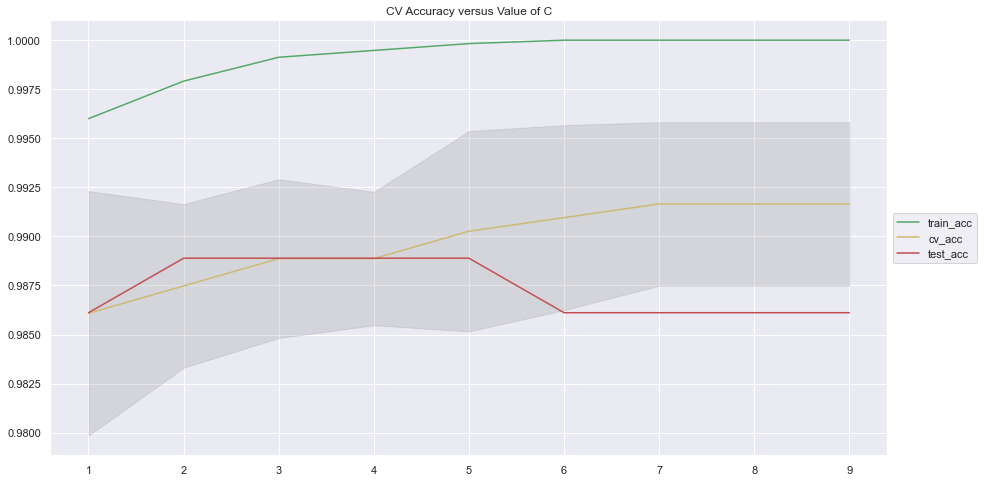

In [21]:
# curva de validacion

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve


parameters = {'kernel':['rbf'], 'C': np.arange(1,10)}
svm = SVC()
gs = GridSearchCV(svm, parameters,return_train_score=True)
gs.fit(X_train,y_train)
C_values= np.arange(1,10)
test_accuracy = []
for C_val in C_values:
    svm = SVC(kernel='rbf', C=C_val)
    svm.fit(X_train,y_train)
    test_accuracy.append(svm.score(X_test,y_test))


fig, ax = plt.subplots(figsize=(15,8))
ax.plot(C_values,gs.cv_results_['mean_train_score'],color='g',lw=1.5,label='train_acc')
ax.plot(C_values,gs.cv_results_['mean_test_score'],color='y',lw=1.5,label='cv_acc')
ax.plot(C_values,test_accuracy,color='r',lw=1.5,label='test_acc')
plt.fill_between(C_values, gs.cv_results_['mean_test_score']-gs.cv_results_['std_test_score'], gs.cv_results_['mean_test_score']+gs.cv_results_['std_test_score'],color='gray', alpha=0.2)
plt.title("CV Accuracy versus Value of C")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

La conclusión del gráfico es que el mejor parámetro C correspondería a $C=4$, pues es el que cumple la regla de la menor desviación estándar, lo que coincide con un buen score para un conjunto de test, a diferencia de la elección de gridsearch de $C=7$, donde se ve que el score para el conjunto de test no es tan bueno.

In [22]:
# curva roc

from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from itertools import cycle

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

%matplotlib inline



# Binarize the output
y = label_binarize(y, classes=[i for i in range(10)])
n_classes = y.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=42)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(SVC(kernel='rbf', C=4, probability=True,
                                 random_state=42))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

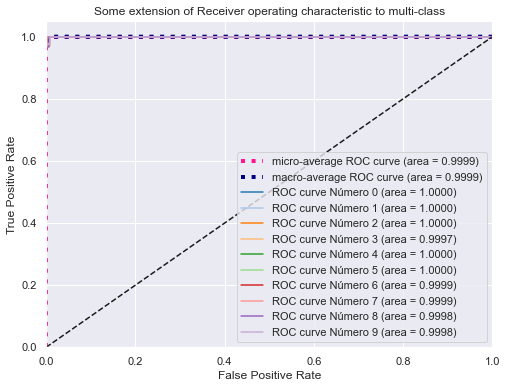

In [23]:
import matplotlib.colors

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,6))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle([plt.cm.tab20(i) for i in range(10)])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve Número {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

En general todas las categorías de números a predecir son bien predichas por el modelo, con un accuracy bastante bueno. Los caso en los que existen errores, sin ambargo, muy pocos, son los casos en 3 y 8 por ejemplo, esto podría explicarse debido a la forma parecida de los números. Al igual que con el 6 y el 9.

### Ejercicio 5
__Reducción de la dimensión:__ Tomando en cuenta el mejor modelo encontrado en el `Ejercicio 3`, debe realizar una redcción de dimensionalidad del conjunto de datos. Para ello debe abordar el problema ocupando los dos criterios visto en clases:  

* **Selección de atributos**
* **Extracción de atributos**

__Preguntas a responder:__

Una vez realizado la reducción de dimensionalidad, debe sacar algunas estadísticas y gráficas comparativas entre el conjunto de datos original y el nuevo conjunto de datos (tamaño del dataset, tiempo de ejecución del modelo, etc.)


In [40]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Separamos las columnas objetivo
x_training = digits.drop(['target'], axis=1)
y_training = digits['target']

# Aplicando el algoritmo univariante de prueba F.
k = 50  # número de atributos a seleccionar
columnas = list(x_training.columns.values)
seleccionadas = SelectKBest(f_classif, k=k).fit(x_training, y_training)

In [41]:
catrib = seleccionadas.get_support()
atributos = [columnas[i] for i in list(catrib.nonzero()[0])]
atributos

['c01',
 'c02',
 'c03',
 'c04',
 'c05',
 'c06',
 'c07',
 'c09',
 'c10',
 'c11',
 'c12',
 'c13',
 'c14',
 'c17',
 'c18',
 'c19',
 'c20',
 'c21',
 'c22',
 'c25',
 'c26',
 'c27',
 'c28',
 'c29',
 'c30',
 'c33',
 'c34',
 'c35',
 'c36',
 'c37',
 'c38',
 'c41',
 'c42',
 'c43',
 'c44',
 'c45',
 'c46',
 'c50',
 'c51',
 'c52',
 'c53',
 'c54',
 'c55',
 'c57',
 'c58',
 'c59',
 'c60',
 'c61',
 'c62',
 'c63']

In [42]:
NB2=KNeighborsClassifier()
ti=time()
NB2.fit(x_training, y_training)
tf=time()
tp=tf-ti
print("el tiempo de ejecucion de NB es de", tp, "segundos")

el tiempo de ejecucion de NB es de 0.0039882659912109375 segundos


In [43]:
df=digits[atributos]
df['target']=digits['target']
df.head()

,c01,c02,c03,c04,c05,c06,c07,c09,c10,c11,...,c54,c55,c57,c58,c59,c60,c61,c62,c63,target
0,0,5,13,9,1,0,0,0,13,15,...,0,0,0,6,13,10,0,0,0,0
1,0,0,12,13,5,0,0,0,0,11,...,0,0,0,0,11,16,10,0,0,1
2,0,0,4,15,12,0,0,0,3,16,...,5,0,0,0,3,11,16,9,0,2
3,0,7,15,13,1,0,0,8,13,6,...,9,0,0,7,13,13,9,0,0,3
4,0,0,1,11,0,0,0,0,0,7,...,0,0,0,0,2,16,4,0,0,4


In [44]:
print(df.size)
print(digits.size)
print('claramente el dataset es mayor para digits que df')

91647
116805
claramente el dataset es mayor para digits que df


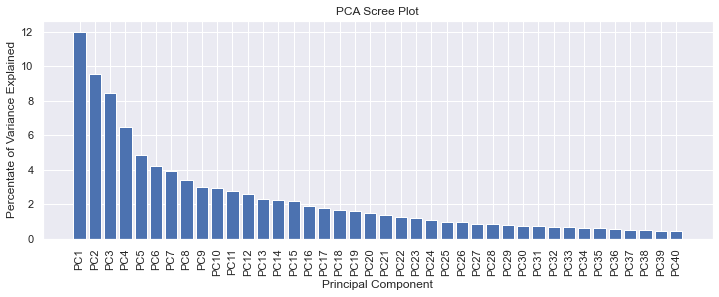

In [52]:
# ajustar modelo
from sklearn.decomposition import PCA
n=40
pca = PCA(n_components=n)
principalComponents = pca.fit_transform(X_escal)

# graficar varianza por componente
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = ['PC'+ str(i) for i in range(1,n+1)]

plt.figure(figsize=(12,4))
plt.bar(x= range(1,n+1), height=percent_variance, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.xticks(rotation=90)
plt.show()

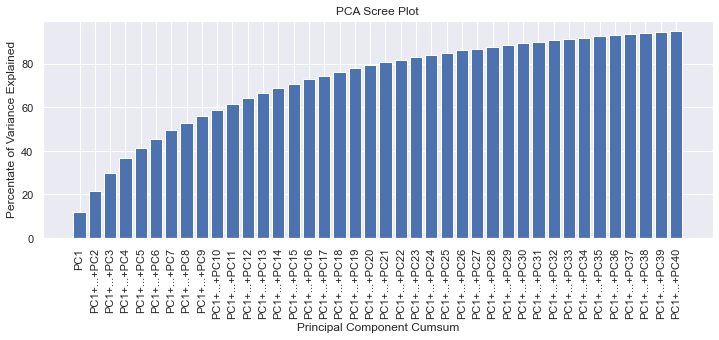

In [53]:
# graficar varianza por la suma acumulada de los componente
percent_variance_cum = np.cumsum(percent_variance)
columns = ['PC1' + '+...+' + 'PC' + str(i) for i in range(2,n+1)]
columns.insert(0, 'PC1')

plt.figure(figsize=(12,4))
plt.bar(x= range(1,n+1), height=percent_variance_cum, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component Cumsum')
plt.title('PCA Scree Plot')
plt.xticks(rotation=90)
plt.show()

In [54]:
percent_variance_cum

array([12.03, 21.59, 30.03, 36.53, 41.39, 45.6 , 49.54, 52.93, 55.93,
       58.86, 61.64, 64.22, 66.5 , 68.73, 70.9 , 72.81, 74.59, 76.23,
       77.83, 79.32, 80.67, 81.94, 83.11, 84.17, 85.15, 86.09, 86.95,
       87.79, 88.59, 89.34, 90.07, 90.76, 91.41, 92.05, 92.64, 93.21,
       93.73, 94.21, 94.66, 95.08])

notamos que si tomamos las primeras $40$ componentes principales, podemos explicar las demás variables del modelo en un 95.1%


In [55]:
pca = PCA(n_components=40)

principalComponents = pca.fit_transform(X)

principalDataframe = pd.DataFrame(data = principalComponents, columns = ['PC'+str(i) for i in range(1,41)])
targetDataframe = digits[['target']]

newDataframe = pd.concat([principalDataframe, targetDataframe],axis = 1)
newDataframe.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,target
0,-1.259466,21.274883,-9.463055,13.014189,-7.128823,-7.440659,3.252837,2.553470,-0.581842,3.625697,...,-0.755014,0.162838,-2.112986,1.094826,0.195673,-0.090000,-2.763698,1.088889,0.206087,0
1,7.957611,-20.768699,4.439506,-14.893664,5.896249,-6.485622,2.126228,-4.615936,3.587450,-1.074705,...,1.290907,-2.154407,0.166806,3.191428,-1.532268,-3.688113,2.073792,-0.230846,0.722357,1
2,6.991923,-9.955986,2.958558,-12.288302,-18.126023,-4.507664,1.843122,-16.415200,0.719233,4.255805,...,0.450444,0.341087,-0.505612,-2.808247,-1.253864,-0.220565,0.038177,1.108648,3.285135,2
3,-15.906105,3.332464,9.824372,-12.275838,6.965169,1.089483,-1.042085,10.973556,-3.259735,6.498753,...,2.086400,3.220692,-0.826726,-1.392380,2.075338,-1.291334,1.963142,1.893076,0.675714,3
4,23.306867,4.269061,-5.675129,-13.851524,-0.358124,-2.857574,-0.720497,13.041696,-3.835413,13.414164,...,0.405450,-0.079861,1.284007,1.015916,3.805720,0.627320,-0.159854,-2.986689,-0.397604,4


In [56]:
#Estadisticas para PCA

model_pca = sm.OLS(targetDataframe, sm.add_constant(principalDataframe))
results = model_pca.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     61.41
Date:                Sun, 12 Dec 2021   Prob (F-statistic):          6.96e-300
Time:                        22:06:49   Log-Likelihood:                -3654.8
No. Observations:                1797   AIC:                             7392.
Df Residuals:                    1756   BIC:                             7617.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4908      0.044    101.752      0.0

In [57]:
#Crear dataframe para PCA

total_nuevo_pca = principalComponents.shape[0]*principalComponents.shape[1]

df_comparar_pca = pd.DataFrame(columns=['Df', 'counts'])
df_comparar_pca.loc[0]= ['Original',total_original]
df_comparar_pca.loc[1]= ['Nuevo',total_nuevo_pca]

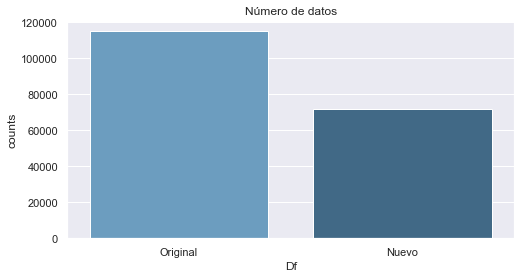

La cantidad de datos del DataFrame original es: 115008
La cantidad de datos del DataFrame despues de la selección es: 71880


In [58]:
fig, ax = plt.subplots(figsize=(8,4),nrows=1)
sns.barplot(data=df_comparar_pca, x='Df', y='counts', palette="Blues_d",ax=ax)
ax.set_title('Número de datos')
plt.show()
print("La cantidad de datos del DataFrame original es:", total_original)
print("La cantidad de datos del DataFrame despues de la selección es:", total_nuevo_pca)

In [59]:
X_pca= principalComponents
y_pca= targetDataframe

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=.2,
                                                    random_state=42)

In [60]:
#Entrenar modelo
clf_pca = SVC(kernel= 'rbf', C=7)
print("Tiempo de ejecución del modelo")
%timeit  clf_pca.fit(X_train_pca, y_train_pca)

#Predicción
y_pred_pca= clf_pca.predict(X_test_pca)

#Evaluar
confusion_matrix(y_test_pca, y_pred_pca)

Tiempo de ejecución del modelo
101 ms ± 3.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


array([[33,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 33,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 33,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 46,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 46,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 35,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 33,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 30,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0, 39]], dtype=int64)

In [61]:
#Métricas
target_names = ['numero '+ str(i) for i in range(0,10)]
print(classification_report(y_test_pca, y_pred_pca, target_names=target_names, digits=5))

              precision    recall  f1-score   support

    numero 0    1.00000   1.00000   1.00000        33
    numero 1    1.00000   1.00000   1.00000        28
    numero 2    1.00000   1.00000   1.00000        33
    numero 3    1.00000   0.97059   0.98507        34
    numero 4    1.00000   1.00000   1.00000        46
    numero 5    0.97872   0.97872   0.97872        47
    numero 6    0.97222   1.00000   0.98592        35
    numero 7    0.97059   0.97059   0.97059        34
    numero 8    1.00000   1.00000   1.00000        30
    numero 9    0.97500   0.97500   0.97500        40

    accuracy                        0.98889       360
   macro avg    0.98965   0.98949   0.98953       360
weighted avg    0.98897   0.98889   0.98889       360



### Ejercicio 6


__Visualizando Resultados:__ A continuación se provee código para comparar las etiquetas predichas vs las etiquetas reales del conjunto de _test_. 


In [62]:
def mostar_resultados(digits,model,nx=5, ny=5,label = "correctos"):
    """
    Muestra los resultados de las prediciones de un modelo 
    de clasificacion en particular. Se toman aleatoriamente los valores
    de los resultados.
    
    - label == 'correcto': retorna los valores en que el modelo acierta.
    - label == 'incorrecto': retorna los valores en que el modelo no acierta.

    
    Observacion: El modelo que recibe como argumento debe NO encontrarse
    'entrenado'.
    
    
    :param digits: dataset 'digits'
    :param model: modelo de sklearn
    :param nx: numero de filas (subplots)
    :param ny: numero de columnas (subplots)
    :param label: datos correctos o incorrectos
    :return: graficos matplotlib
    """
    
    
    X = digits.drop(columns="target").values
    Y = digits["target"].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 42) 
    model.fit(X_train, Y_train) # ajustando el modelo
    Y_pred = list(model.predict(X_test))

    
    # Mostrar los datos correctos
    if label=="correctos":
        mask = Y_pred == Y_test
        color = "green"
        
    # Mostrar los datos correctos
    elif label=="incorrectos":
        mask = Y_pred != Y_test
        color = "red"
    
    else:
        raise ValueError("Valor incorrecto")
        
    X_aux = X_test[mask]
    y_aux_true = np.array(Y_test)[mask]
    y_aux_pred = np.array(Y_pred)[mask]

    # We'll plot the first 100 examples, randomly choosen
    fig, ax = plt.subplots(nx, ny, figsize=(12,12))
    for i in range(nx):
        for j in range(ny):
            index = j + ny * i
            data  = X_aux[index, :].reshape(8,8)
            label_pred = str(int(y_aux_pred[index]))
            label_true = str(int(y_aux_true[index]))
            ax[i][j].imshow(data, interpolation='nearest', cmap='gray_r')
            ax[i][j].text(0, 0, label_pred, horizontalalignment='center', verticalalignment='center', fontsize=10, color=color)
            ax[i][j].text(7, 0, label_true, horizontalalignment='center', verticalalignment='center', fontsize=10, color='blue')
            ax[i][j].get_xaxis().set_visible(False)
            ax[i][j].get_yaxis().set_visible(False)
    plt.show()

**Pregunta**

* Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, grafique los resultados cuando:
 * el valor predicho y original son iguales
 * el valor predicho y original son distintos 




In [63]:
modelo = SVC(kernel= 'rbf', C=4) # Mejor modelo

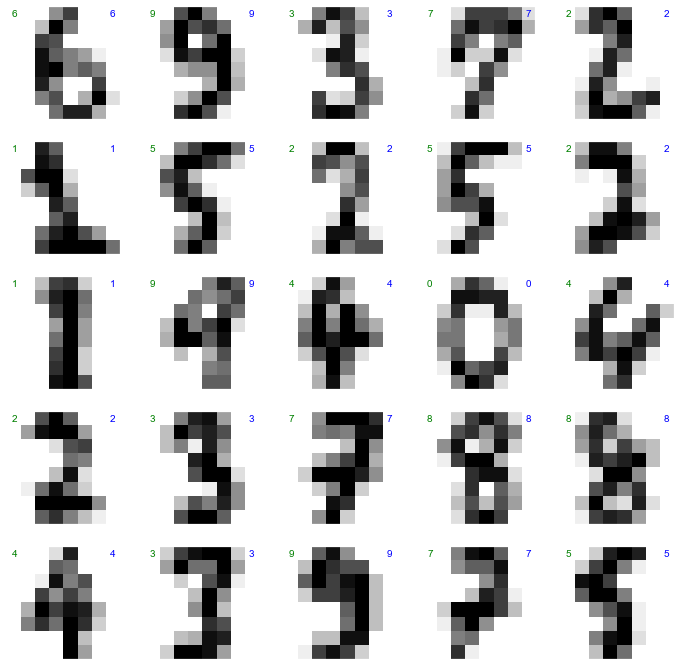

In [64]:
mostar_resultados(digits,modelo,nx=5, ny=5,label = "correctos")

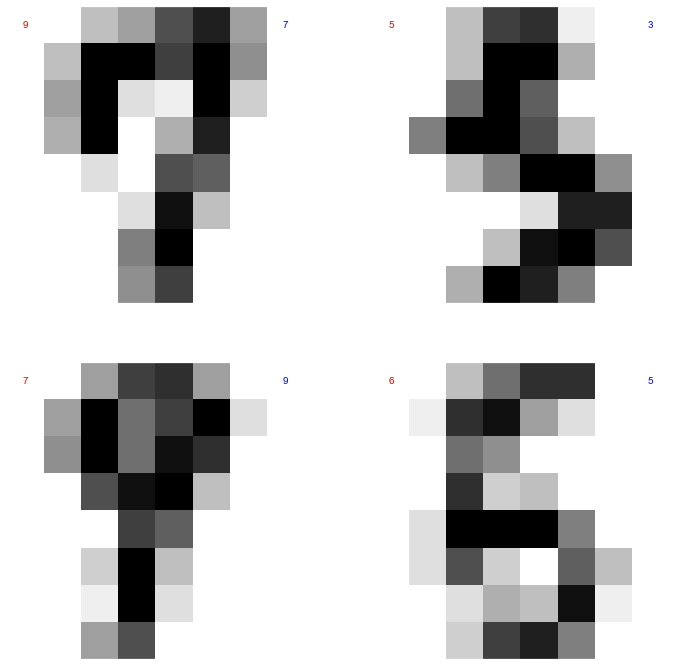

In [65]:
mostar_resultados(digits,modelo,nx=2, ny=2,label = "incorrectos")

* Cuando el valor predicho y original son distintos ,  ¿Por qué ocurren estas fallas?



ya que visualmente los valores supuestamente verdaderos, generan mucha confusión con otros números, por ejemplo, el que tiene como valor real 5, visualmente parece un 6. Llevando esto a SVM, deben ser puntos muy cercanos a la frontera de decisión de SVM, los cuales son puntos que el hiperplano no tiene tanta seguridad al clasificar.

### Ejercicio 7
**Conclusiones**: Entrega tu veredicto, responde las preguntas iniciales, visualizaciones, trabajos futuros, dificultades, etc.

Se uso modelo segun las mejores métricas y tiempo de ejecucion, la que entregan los resultados de cada cifra, cuyo resultado arroja algunas correctas y otras incorrectas el modelo tuvo una buena exactitud, ya que si bien el modelo tiene buenas metricas, estas aun no son perfectas.
Si se pudiese mejorar los parámetros de las funciones esto podría mejorar las predicciones.

## II.- California Housing Prices


<img src="https://www.wartsila.com/images/default-source/default-album/california_housing.tmb-1920x690.jpg?sfvrsn=126bc44_1" width="480" height="240" align="center"/>

Los datos se refieren a las casas encontradas en un distrito determinado de California y algunas estadísticas resumidas sobre ellas basadas en los datos del censo de 1990. Tenga en cuenta que los datos no se limpian, por lo que se requieren algunos pasos de procesamiento previo.

Las columnas son las siguientes, sus nombres se explican por sí mismos:

* longitude
* latitude
* housingmedianage
* total_rooms
* total_bedrooms
* population
* households
* median_income
* medianhousevalue
* ocean_proximity


El objetivo es poder predecir el valor promedio de cada propiedad. 
Para poder completar correctamente este laboratorio, es necesario seguir la siguiente rúbrica de trabajo:

1. Definición del problema
2. Estadística descriptiva
3. Visualización descriptiva
4. Preprocesamiento
5. Selección de modelo 
    1. Por lo menos debe comparar cuatro modelos
    2. Al menos tres de estos modelos tienen que tener hiperparámetros.
    3. Realizar optimización de hiperparámetros.
6. Métricas y análisis de resultados
7. Visualizaciones del modelo
8. Conclusiones

> **Observación**: Puede tomar como referencia lo realizado en la sección **I.- Clasificación de dígitos**. El alumno tiene la libertad de desarrollar un análisis más completo del problema (si así lo desea). Puede tomar como referencia el siguiente [link](https://www.kaggle.com/camnugent/california-housing-prices).

In [69]:
# read data
housing = pd.read_csv('data/housing.csv',sep=',')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [71]:
# estadistica descriptiva

housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [72]:
housing_numerico=housing.drop('ocean_proximity',axis=1)


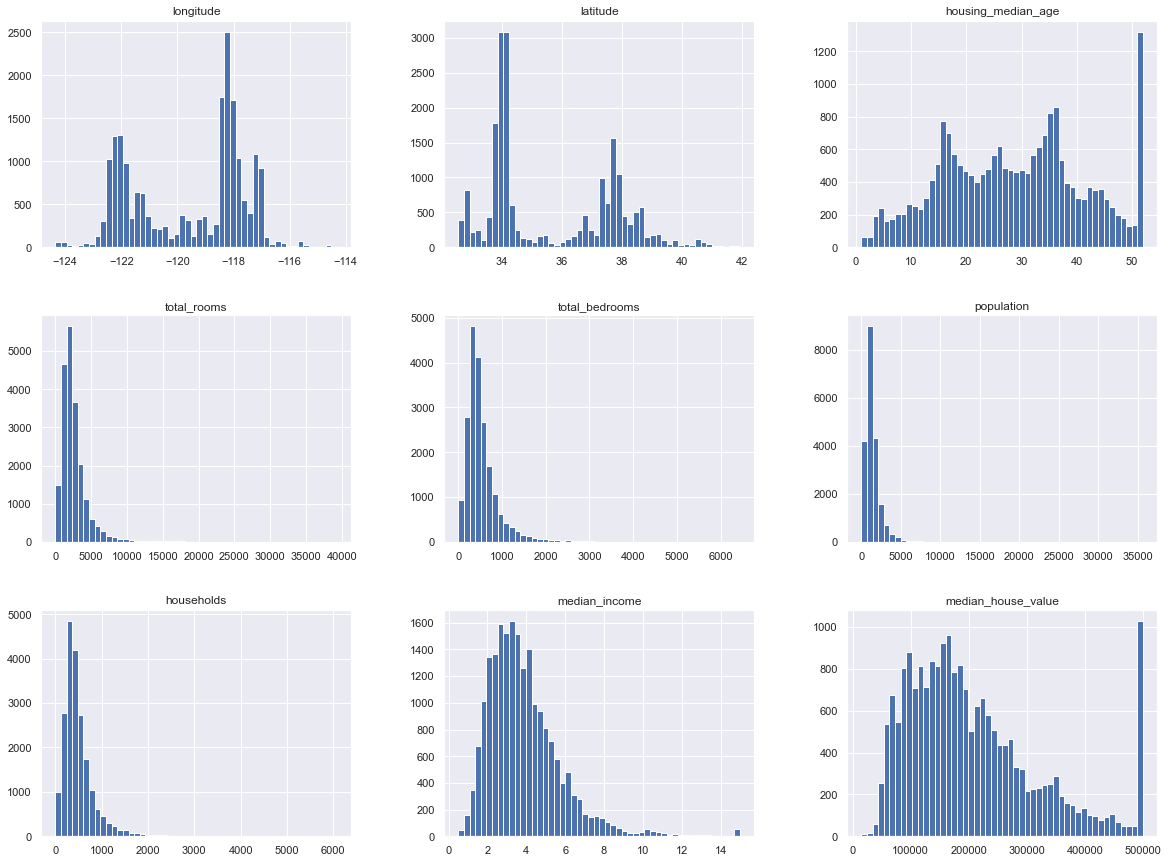

In [73]:
#visualización descriptiva, crearemos los gráficos como en lo anterior

%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50,figsize=(20,15))
plt.show()

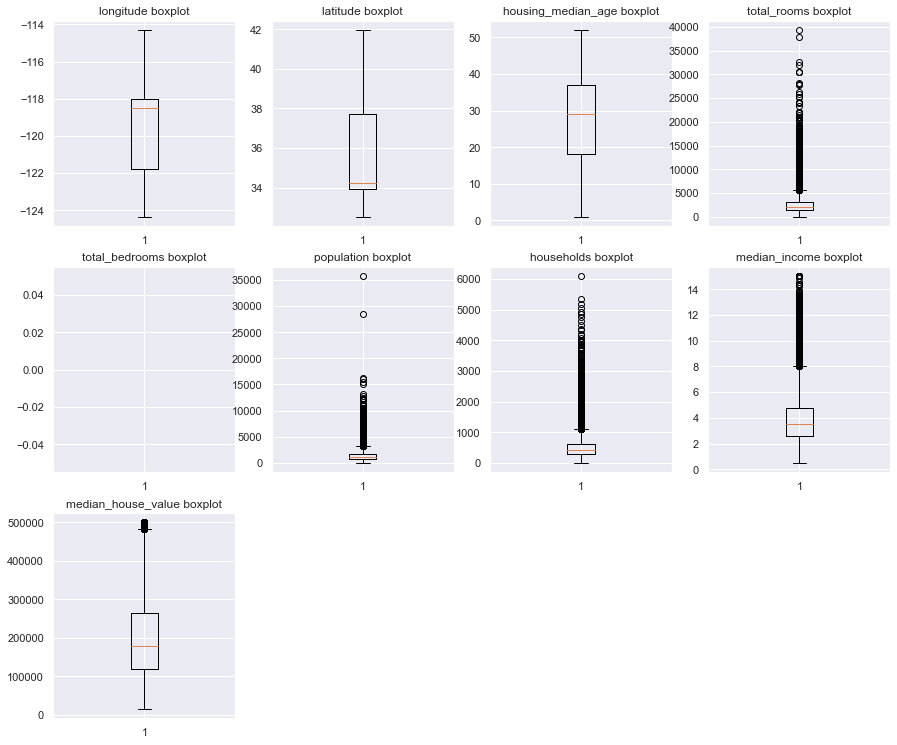

In [107]:
#ademas haré diagramas de cajas, ya que entregan información de variables que no pueden ser facilmente dislumbradas con los graficos anteriores

def outliers_visual(data):
    plt.figure(figsize=(15, 40))
    i = 1
    for col in data.columns:
        plt.subplot(9, 4, i)
        plt.boxplot(data[col])
        plt.title('{} boxplot'.format(col))
        i += 1
    plt.show()
outliers_visual(housing_numerico)

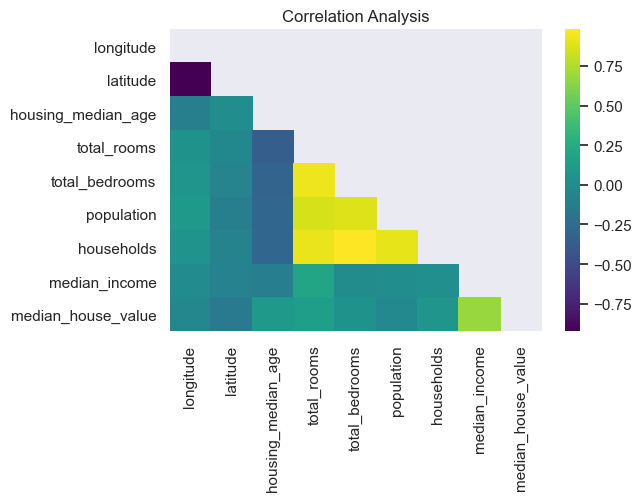

In [108]:
#veamos ahora el preprocesamiento

import seaborn as sns
corr = housing.corr()
mask = np.triu(np.ones_like(corr,dtype = bool))

plt.figure(dpi=100)
plt.title('Correlation Analysis')
sns.heatmap(corr,mask=mask,annot=False,lw=0,cmap='viridis',fmt = "0.2f")
plt.xticks(rotation=90)
plt.yticks(rotation = 0)
plt.show()

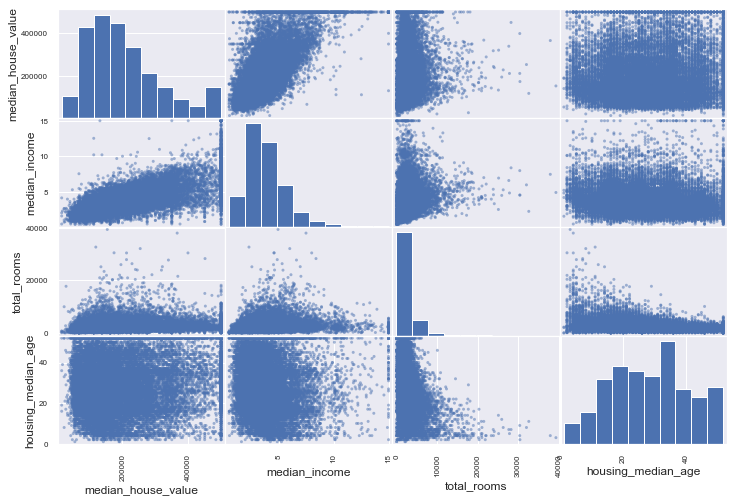

In [76]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

columnas = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[columnas], figsize=(12, 8))
plt.show()

In [77]:
housing=housing.dropna()
X = housing.drop(["median_house_value","ocean_proximity"], axis=1) #entrenamiento 
y = housing["median_house_value"].copy()

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

print('Largo del conjunto de entrenamiento: ', len(X_train))
print('Largo del conjunto de testeo: ', len(X_test))

Largo del conjunto de entrenamiento:  15324
Largo del conjunto de testeo:  5109


In [79]:
#seleccion de modelos

In [81]:
#regresión lineal

from sklearn.linear_model import LinearRegression
lineal_reg=LinearRegression()
lineal_reg.fit(X_train,y_train)

LinearRegression()

In [84]:
y_true_RL =  list(y_test)
y_pred_RL = list(lineal_reg.predict(X_test))

In [86]:
from metrics_regression import *
from sklearn.metrics import r2_score
# ejemplo 
df_temp = pd.DataFrame(
    {
        'y':y_true_RL,
        'yhat':y_pred_RL
        }
)

df_metrics2 = summary_metrics(df_temp)
df_metrics2['r2']=r2_score(y_true_RL,y_pred_RL)
print("\nMetricas para los regresores")
print("")
df_metrics2


Metricas para los regresores



,mae,mse,rmse,mape,maape,wmape,mmape,smape,r2
0,50995.2334,4.947531e+09,70338.6871,0.3131,0.2717,0.249,0.3131,0.2813,0.614854


In [87]:
#arbol de desicion

In [88]:
from sklearn.tree import DecisionTreeRegressor
param = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20]}
dtr = DecisionTreeRegressor(random_state = 1)
grid_search_DTR = GridSearchCV(estimator = dtr,
                        param_grid = param,
                        cv = 3,
                       return_train_score=True)

In [89]:
grid_search_DTR.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=1),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20]},
             return_train_score=True)

In [90]:
grid_search_DTR.best_params_

{'max_depth': 9}

In [91]:
grid_search_DTR.best_estimator_

DecisionTreeRegressor(max_depth=9, random_state=1)

In [92]:
#evaluamos

y_true_DT =  list(y_test)
y_pred_DT = list(grid_search_DTR.best_estimator_.predict(X_test))

In [93]:
from metrics_regression import *
# ejemplo 
df_temp = pd.DataFrame(
    {
        'y':y_true_DT,
        'yhat':y_pred_DT
        }
)

df_metrics3 = summary_metrics(df_temp)
df_metrics3['r2']=r2_score(y_true_DT,y_pred_DT)
print("\nMetricas para los regresores")
print("")
df_metrics3


Metricas para los regresores



,mae,mse,rmse,mape,maape,wmape,mmape,smape,r2
0,43198.9125,4.173874e+09,64605.5249,0.2464,0.2158,0.2109,0.2464,0.2164,0.67508


In [94]:
#random forest

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=6, random_state=2)

In [95]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search_forest_reg = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search_forest_reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [96]:
grid_search_forest_reg.best_params_

{'max_features': 6, 'n_estimators': 30}

In [97]:
grid_search_forest_reg.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30, random_state=42)

In [98]:
#evaluacion

y_true_RF =  list(y_test)
y_pred_RF = list(grid_search_forest_reg.predict(X_test))

from metrics_regression import *
from sklearn.metrics import r2_score
# ejemplo 
df_temp = pd.DataFrame(
    {
        'y':y_true_RF,
        'yhat':y_pred_RF
        }
)

df_metrics4 = summary_metrics(df_temp)
df_metrics4['r2']=r2_score(y_true_RF,y_pred_RF)
print("\nMetricas para los regresores")
print("")
df_metrics4


Metricas para los regresores



,mae,mse,rmse,mape,maape,wmape,mmape,smape,r2
0,32561.5115,2.502975e+09,50029.7448,0.1844,0.1647,0.159,0.1844,0.1645,0.805153


In [99]:
#regresion bayesiana

from sklearn import linear_model
bay_reg = linear_model.BayesianRidge()
param_grid={'alpha_1':[0.1,0.2,0.3,0.4,1,2,5],
            'alpha_2':[0.1,0.2,0.3,0.4,1,2,5],
            'lambda_1':[0.1,0.2,0.3,0.4,1,2,5],
            'lambda_2':[0.1,0.2,0.3,0.4,1,2,5]}
grid_bay_reg=GridSearchCV(bay_reg,param_grid,cv=5,)

In [100]:
grid_bay_reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=BayesianRidge(),
             param_grid={'alpha_1': [0.1, 0.2, 0.3, 0.4, 1, 2, 5],
                         'alpha_2': [0.1, 0.2, 0.3, 0.4, 1, 2, 5],
                         'lambda_1': [0.1, 0.2, 0.3, 0.4, 1, 2, 5],
                         'lambda_2': [0.1, 0.2, 0.3, 0.4, 1, 2, 5]})

In [101]:
grid_bay_reg.best_params_

{'alpha_1': 5, 'alpha_2': 2, 'lambda_1': 0.1, 'lambda_2': 5}

In [102]:
grid_bay_reg.best_estimator_


BayesianRidge(alpha_1=5, alpha_2=2, lambda_1=0.1, lambda_2=5)

In [103]:
#evaluamos

y_true_BR =  list(y_test)
y_pred_BR = list(grid_bay_reg.best_estimator_.predict(X_test))

from metrics_regression import *
from sklearn.metrics import r2_score
# ejemplo 
df_temp = pd.DataFrame(
    {
        'y':y_true_BR,
        'yhat':y_pred_BR
        }
)

df_metrics1 = summary_metrics(df_temp)
df_metrics1['r2']=r2_score(y_true_BR,y_pred_BR)
print("\nMetricas para los regresores")
print("")
df_metrics1


Metricas para los regresores



,mae,mse,rmse,mape,maape,wmape,mmape,smape,r2
0,50993.8833,4.947542e+09,70338.7681,0.313,0.2717,0.249,0.313,0.2813,0.614853


In [105]:
#buscaremos el mejor modelo uniendolos

df=pd.concat([df_metrics1,df_metrics2,df_metrics3,df_metrics4])
df['Modelo']=['Bayesian Regression','Regresion lineal','Desicion tree regressor','Random Forest']
df

,mae,mse,rmse,mape,maape,wmape,mmape,smape,r2,Modelo
0,50993.8833,4.947542e+09,70338.7681,0.3130,0.2717,0.2490,0.3130,0.2813,0.614853,Bayesian Regression
0,50995.2334,4.947531e+09,70338.6871,0.3131,0.2717,0.2490,0.3131,0.2813,0.614854,Regresion lineal
0,43198.9125,4.173874e+09,64605.5249,0.2464,0.2158,0.2109,0.2464,0.2164,0.675080,Desicion tree regressor
0,32561.5115,2.502975e+09,50029.7448,0.1844,0.1647,0.1590,0.1844,0.1645,0.805153,Random Forest


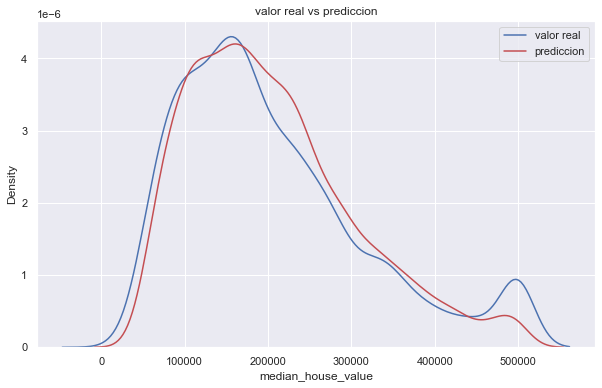

In [106]:
#para comprobar la veracidad de los modelos crearemos un gráfico valor real vs prediccion que visualice los modelos

y_pred = y_pred_RF
plt.figure(figsize=(10, 6))

ax = sns.distplot(y_test, hist=False, color="b", label="valor real")
sns.distplot(y_pred, hist=False, color="r", label="prediccion" , ax=ax)

plt.title('valor real vs prediccion')
plt.legend()
plt.show()

Notemos que los valores anteriores manifiestan que el mejor modelo es Random forest, pues del gráfico se puede comprobar que la prediccion es muy parecido al valor real, por lo cual es una buena predicción